# Making it a bit harder

We are going to increase the complexity on two levels:

* We are going to add chords and bass instruments
* We are going to let the lead synthesizer play multiple notes at once

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from music_generator.basic.random import generate_dataset, make_lead_instrument, generate_lead_track
from music_generator.musical.timing import Tempo, Signature, Duration
from music_generator.basic.signalproc import SamplingInfo, mix_at
from music_generator.analysis.plots import set_style
from music_generator.musical.scales import GenericScale
from music_generator.musical.songs import Track, Measure

from scipy.signal import stft

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import datetime as dt
%matplotlib inline

from IPython.display import Audio

In [3]:
set_style()

In [4]:
sr = 44100
sampling_info = SamplingInfo(sr)
scale = GenericScale('C', [0, 1, 4, 5, 7, 8, 10])
signature = Signature(4, 4)
n_measures = 128
tempo = t = Tempo(120)

In [5]:
lead_instrument = make_lead_instrument(sampling_info)

In [6]:
tracks, parts, mix = generate_dataset(n_measures, Tempo(120), scale=scale)

In [7]:
trk_bass, trk_chord, trk_lead = tracks
y_bass, y_chord, y_lead = parts

## Add harmony

In [8]:
lead_track = generate_lead_track(scale, tempo, signature, n_measures, 4)

In [9]:
terts = pd.DataFrame({'note': scale.generate(4, 8)[:-2], 'harm': scale.generate(4, 8)[2:]})

df_harm = pd.merge(pd.DataFrame({'note': [n.note for n in trk_lead.generate_notes()],
                                 'offset': [n.offset for n in trk_lead.generate_notes()],
                                 'duration': [n.duration for n in trk_lead.generate_notes()],
                                 'velocity': [n.velocity for n in trk_lead.generate_notes()]
                                }), terts, on='note')

In [10]:
measure = Measure(t, Signature(4, 4))
for i, row in df_harm.iterrows():
    measure.add_note(row.harm, row.offset.beats(t), row.duration.beats(t), row.velocity)
    measure.add_note(row.note, row.offset.beats(t), row.duration.beats(t), row.velocity)
trk_lead = Track([measure])

y_lead = lead_instrument.generate_track(trk_lead)

In [11]:
mix = mix_at(y_bass, y_chord)
mix = mix_at(mix, y_lead)

## End mix harmony

In [12]:
df = pd.DataFrame()

df['offset'] = [x.offset.seconds for x in trk_lead.generate_notes()]
df['duration'] = [x.duration.seconds for x in trk_lead.generate_notes()]
df['end'] = df['offset'] + df['duration']
df['note'] = [str(x.note) for x in trk_lead.generate_notes()]
df = df.groupby(['offset', 'end', 'note']).size().unstack('note').fillna(0).astype(int)
note_cols = df.columns
df = df.reset_index()

In [13]:
note_cols = [str(x) for x in 
             pd.Series([x.note for x in trk_lead.generate_notes()]).sort_values().drop_duplicates()][1:]

In [14]:
df;

In [15]:
Audio(mix[0:10*sr] , rate=sr)

## The Fourier spectrum shows that the problem is much harder now!

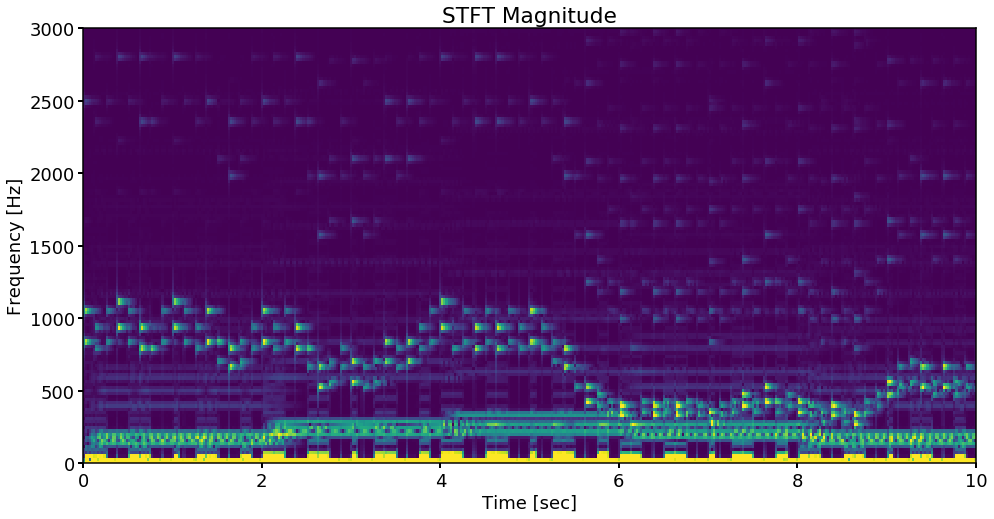

In [16]:
f_vec, t_vec, Zxx = stft(mix, sampling_info.sample_rate, nperseg=2048)
plt.pcolormesh(t_vec, f_vec, np.abs(Zxx), vmin=0, vmax=1e-1)
plt.title('STFT Magnitude')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.ylim(0, 3000)
plt.xlim(0, 10);

In [17]:
y_train = np.array([df[(df.offset <= t) & (t < df.end)][note_cols].sum().values for t in t_vec])

In [18]:
df.head(4)

note,offset,end,A#4,A#5,C#4,C#5,C#6,C4,C5,C6,E4,E5,F4,F5,G#4,G#5,G4,G5
0,0.000,0.125,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
1,0.125,0.250,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,0.250,0.375,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
3,0.375,0.500,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0


In [19]:
n_steps = 1
batch_size=32

X_train = np.abs(np.array(Zxx))
X_train = X_train.T
X_train = X_train[0:X_train.shape[0] // n_steps]
X_train = X_train.reshape(X_train.shape[0] // n_steps, n_steps, X_train.shape[1])

In [20]:
X_train = X_train[0:batch_size * (len(X_train) // batch_size)]
y_train = y_train[0:batch_size * (len(X_train) // batch_size)]

In [21]:
from tensorflow.keras import Model
from tensorflow.keras.layers import GRU, Input, Dense

In [23]:
inp = Input(batch_shape=(batch_size,n_steps, f_vec.shape[0]))

gru = GRU(14, stateful=True)
dense = Dense(len(note_cols), activation='sigmoid')

x = inp
x = gru(x)
out = dense(x)

model = Model(inp, out)
model.compile('adam', 'categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(32, 1, 1025)]           0         
_________________________________________________________________
unified_gru (UnifiedGRU)     (32, 14)                  43722     
_________________________________________________________________
dense (Dense)                (32, 15)                  225       
Total params: 43,947
Trainable params: 43,947
Non-trainable params: 0
_________________________________________________________________


In [24]:
X_train.T

array([[[6.34154309e-02, 3.36274464e-01, 2.81649079e-01, ...,
         6.70272025e-02, 6.00157525e-02, 5.29975604e-02]],

       [[4.59220054e-02, 2.49917561e-01, 1.82035120e-01, ...,
         3.35803241e-02, 3.00473337e-02, 2.65231565e-02]],

       [[1.26947290e-02, 1.10119874e-01, 1.04077813e-01, ...,
         3.70254648e-04, 3.74762025e-04, 3.69468459e-04]],

       ...,

       [[3.67312232e-06, 9.34984336e-12, 1.90529781e-12, ...,
         8.77147263e-13, 8.10471413e-13, 1.09768985e-12]],

       [[3.67309707e-06, 9.29447423e-12, 1.90301689e-12, ...,
         8.76145557e-13, 8.08639963e-13, 1.09602507e-12]],

       [[3.67308800e-06, 9.27594113e-12, 1.90225613e-12, ...,
         8.75820250e-13, 8.08030726e-13, 1.09547094e-12]]])

In [25]:
val_split = 0.125
n_too_much = len(X_train) * val_split % batch_size
n_val_split = len(X_train) * val_split - n_too_much
val_split = n_val_split / len(X_train)
val_split

0.1246376811594203

In [26]:
history = model.fit(X_train, 
                    y_train, 
                    batch_size=batch_size, 
                    epochs=300, validation_split=val_split, verbose=0)

Get some coffee

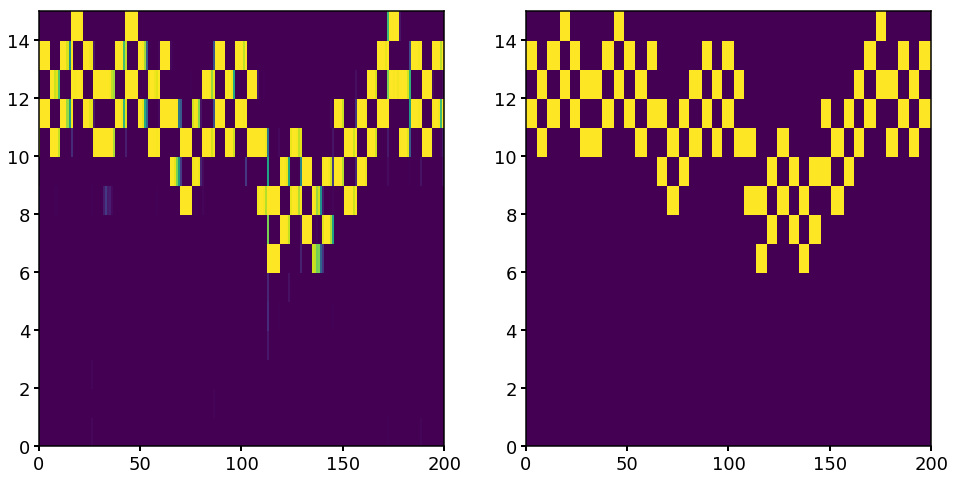

In [27]:
y_pred = model.predict(X_train, batch_size=batch_size)

fig, ax = plt.subplots(1, 2)
sel = np.arange(0, 200)

plt.sca(ax[0])
plt.pcolormesh(y_pred[sel].T, vmin=0, vmax=1)
plt.sca(ax[1])
plt.pcolormesh(y_train[sel].T, vmin=0, vmax=1)

In [28]:
nit = 0
while True:
    print(f"{dt.datetime.now().strftime('%H:%M:%S')}: iteration {nit}")
    history = model.fit(X_train, y_train, batch_size=batch_size, epochs=600, 
                        validation_split=val_split, verbose=0)
    
    train_loss = history.history['loss'][-1]
    val_loss = history.history['val_loss'][-1]
    print(f"Training loss: {train_loss}, Validation loss: {val_loss}")
    
    nit += 1

18:34:41: iteration 0


KeyboardInterrupt: 

## After training for a night

In [ ]:
y_pred = model.predict(X_train, batch_size=batch_size)

fig, ax = plt.subplots(1, 2)
sel = np.arange(0, 200)

plt.sca(ax[0])
plt.pcolormesh(y_pred[sel].T, vmin=0, vmax=1)
plt.sca(ax[1])
plt.pcolormesh(y_train[sel].T, vmin=0, vmax=1)